In [69]:
import sys, os
sys.path.insert(0, '..')
import time

import numpy as np
import matplotlib.pyplot as plt
from skimage import color, segmentation
from skimage.measure import regionprops
from skimage.future import graph
from skimage.io import imread

from lib.datasets.download import maybe_download_and_extract
from lib.segmentation.algorithm import slic, quickshift, felzenszwalb
from lib.datasets.mnist import MNIST
from lib.datasets.cifar_10 import Cifar10

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 15)


def _scale(image, scale=8):
    if scale == 1:
        return image
    else:
        image = np.repeat(image, scale, axis=0)
        image = np.repeat(image, scale, axis=1)
        return image
    
    
def _segment_with_mean(image, labels):
    mean_image = np.zeros_like(image)
    props = regionprops(labels + 1)
    
    for i, prop in enumerate(props):
        min_row, min_col, max_row, max_col = prop['bbox']
        sliced_image = image[min_row:max_row, min_col:max_col]
        color = sliced_image[prop['image']].mean(axis=0)
        
        for row, col in prop['coords']:
            mean_image[row, col] = color
        
    return mean_image
    

def showcase_image_segmentation(image, labels, duration, scale=8):
    scaled_image = _scale(image, scale)
    scaled_labels = _scale(labels, scale)
    
    fig = plt.figure()
    fig.add_subplot(321)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image)
    fig.add_subplot(322)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(labels)
    fig.add_subplot(324)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(segmentation.mark_boundaries(scaled_image, scaled_labels, (1, 0, 0)))
    fig.add_subplot(323)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(_segment_with_mean(image, labels))
    fig.add_subplot(325)
    plt.xticks([])
    plt.yticks([])
    rag = graph.rag_mean_color(scaled_image, scaled_labels)
    plt.imshow(graph.draw_rag(scaled_labels, rag, scaled_image, edge_color='#ff0000'))
    
    plt.show()
    
    print('Execution time: {:.5f}s'.format(duration))
    print('Number of segments:', np.unique(labels).shape[0])

# MNIST
Load a single image from the MNIST test dataset.

In [70]:
mnist = MNIST(data_dir='/tmp/mnist')
image = mnist.test._data[0]
image = np.reshape(image, (28, 28))
image = color.gray2rgb(image)
print('Labels:', mnist.label_name(mnist.test._labels[0]))

Extracting /tmp/mnist/train-images-idx3-ubyte.gz
Extracting /tmp/mnist/train-labels-idx1-ubyte.gz
Extracting /tmp/mnist/t10k-images-idx3-ubyte.gz
Extracting /tmp/mnist/t10k-labels-idx1-ubyte.gz
Labels: [7]


## SLIC
Segment image using k-means clustering in Color-(x,y,z) space.

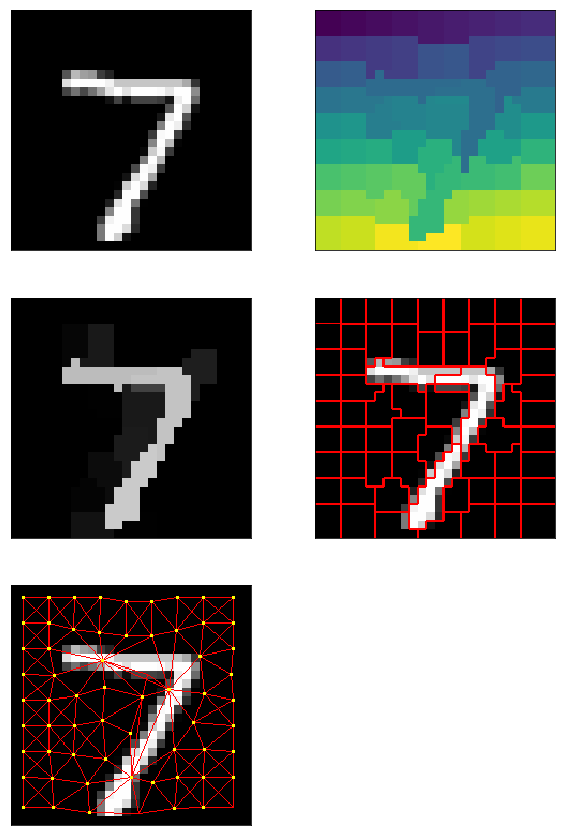

Execution time: 0.00406s
Number of segments: 64


In [54]:
# The (approximate) number of labels in the segmented output image.
NUM_SEGMENTS = 100
# Balances color proximity and space proximity. Higher values give more weight to space proximity,
# making superpixel shapes more square. In SLICO mode, this is the initial compactness.
# This parameter depends strongly on image contrast and on the shapes of objects in the image.
COMPACTNESS = 5
# Maximum number of iterations of k-means.
MAX_ITERATIONS = 10
# Width of gaussian smoothing kernel for preprocessing for each dimension of the image.
# The same sigma is applied to each dimension in case of a scalar value. Zero means no
# smoothing.
SIGMA = 0

t_start = time.process_time()
labels = slic(image, NUM_SEGMENTS, COMPACTNESS, MAX_ITERATIONS, SIGMA)
duration = time.process_time() - t_start

showcase_image_segmentation(image, labels, duration)

## Quickshift
Segment image using quickshift clustering in Color-(x,y) space.

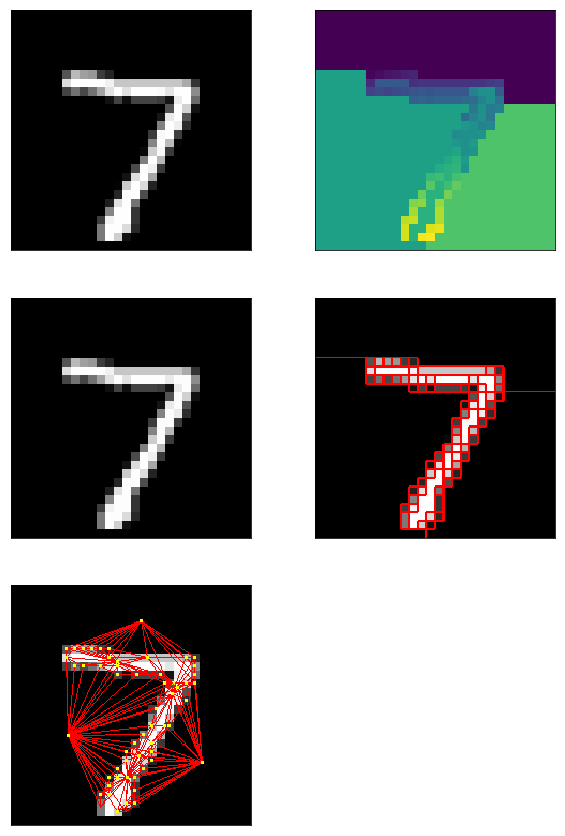

Execution time: 0.01657s
Number of segments: 59


In [55]:
# Balances color-space proximity and image-space proximity. Higher values give more weight to color-space
# (between 0 and 1).
RATIO = 1
# Width of Gaussian kernel used in smoothing the sample density. Higher means fewer clusters.
KERNEL_SIZE = 5
# Cut-off point for data distances. Higher means fewer clusters.
MAX_DIST = 3
# Width for Gaussian smoothing as preprocessing. Zero means no smoothing.
SIGMA = 0

t_start = time.process_time()
labels = quickshift(image, RATIO, KERNEL_SIZE, MAX_DIST, SIGMA)
duration = time.process_time() - t_start

showcase_image_segmentation(image, labels, duration)

## Felzenszwalb
Compute Felsenszwalb’s efficient graph based image segmentation.

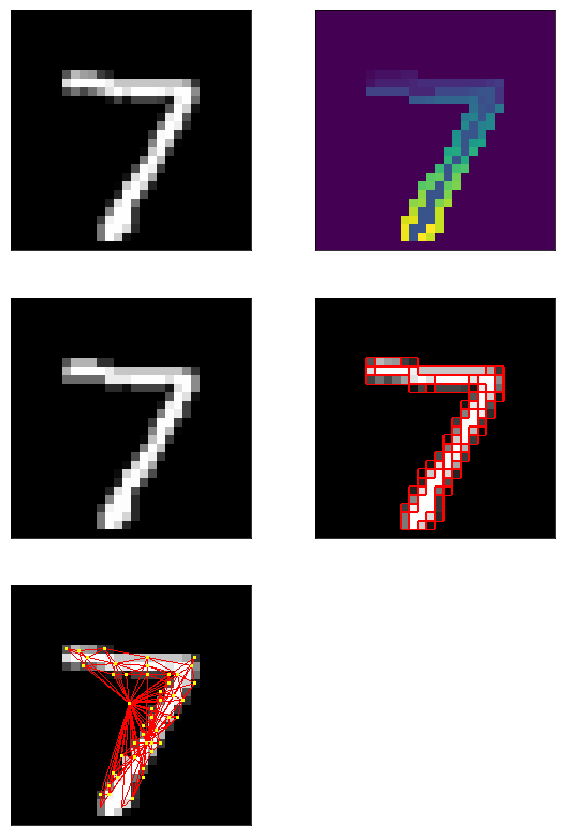

Execution time: 0.00576s
Number of segments: 47


In [56]:
# Higher means larger clusters.
SCALE = 50
# Minimum component size. Enforced using postprocessing.
MIN_SIZE = 1
# Width of Gaussian kernel used in preprocessing.
SIGMA = 0

t_start = time.process_time()
labels = felzenszwalb(image, SCALE, MIN_SIZE, SIGMA)
duration = time.process_time() - t_start

showcase_image_segmentation(image, labels, duration)

# Cifar-10
Load a single image from the Cifar-10 test dataset.

In [72]:
cifar_10 = Cifar10(data_dir='/tmp/cifar_10')
image = cifar_10.test._data[1]
image = np.reshape(image, (32, 32, 3))
print('Labels:', cifar_10.label_name(cifar_10.test._labels[1]))

Labels: ['ship']


## SLIC

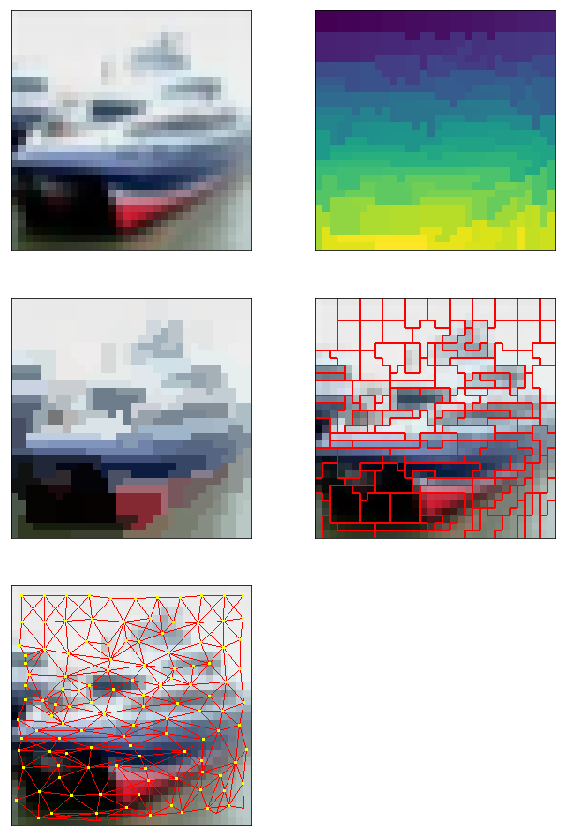

Execution time: 0.00391s
Number of segments: 121


In [58]:
NUM_SEGMENTS = 150
COMPACTNESS = 3
MAX_ITERATIONS = 10
SIGMA = 0

t_start = time.process_time()
labels = slic(image, NUM_SEGMENTS, COMPACTNESS, MAX_ITERATIONS, SIGMA)
duration = time.process_time() - t_start

showcase_image_segmentation(image, labels, duration)

## Quickshift

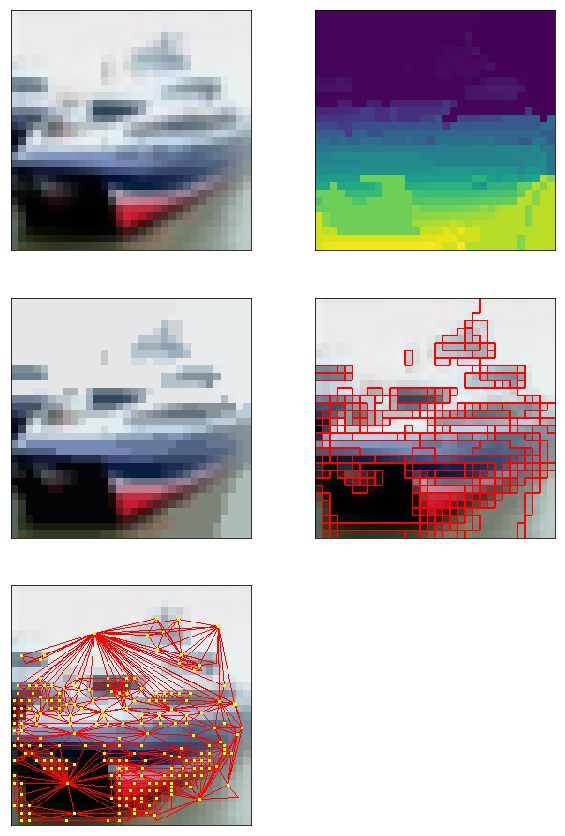

Execution time: 0.01866s
Number of segments: 233


In [59]:
RATIO = 1
KERNEL_SIZE = 5
MAX_DIST = 4
SIGMA = 0

t_start = time.process_time()
labels = quickshift(image, RATIO, KERNEL_SIZE, MAX_DIST, SIGMA)
duration = time.process_time() - t_start

showcase_image_segmentation(image, labels, duration)

## Felzenszwalb

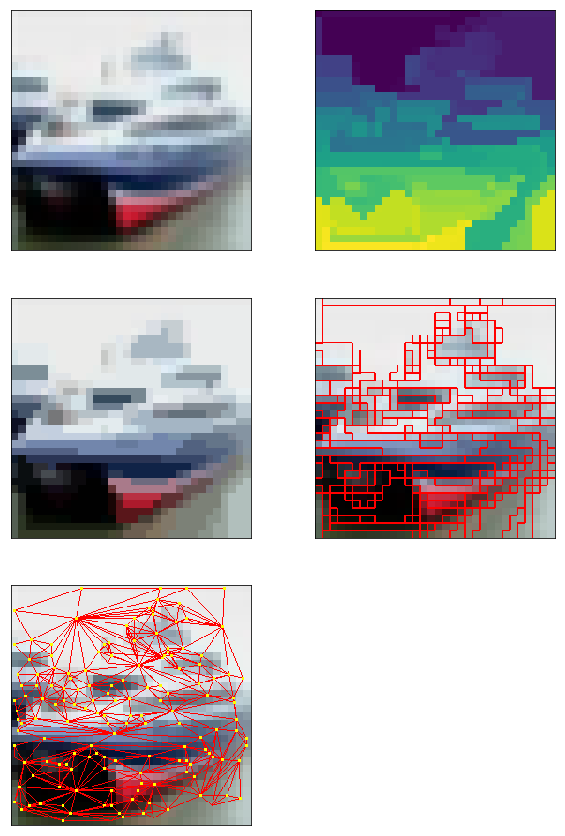

Execution time: 0.00584s
Number of segments: 161


In [81]:
SCALE = 40
MIN_SIZE = 2
SIGMA = 0

t_start = time.process_time()
labels = felzenszwalb(image, SCALE, MIN_SIZE, SIGMA)
duration = time.process_time() - t_start

showcase_image_segmentation(image, labels, duration)

# PascalVOC

In [82]:
URL = 'http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar'
maybe_download_and_extract(URL, '/tmp/pascal_voc')

plt.rcParams['figure.figsize'] = (20, 20)
image = imread('/tmp/pascal_voc/VOCdevkit/VOC2012/JPEGImages/2007_000033.jpg')
image = (1 / 255) * image.astype(np.float32)

## SLIC

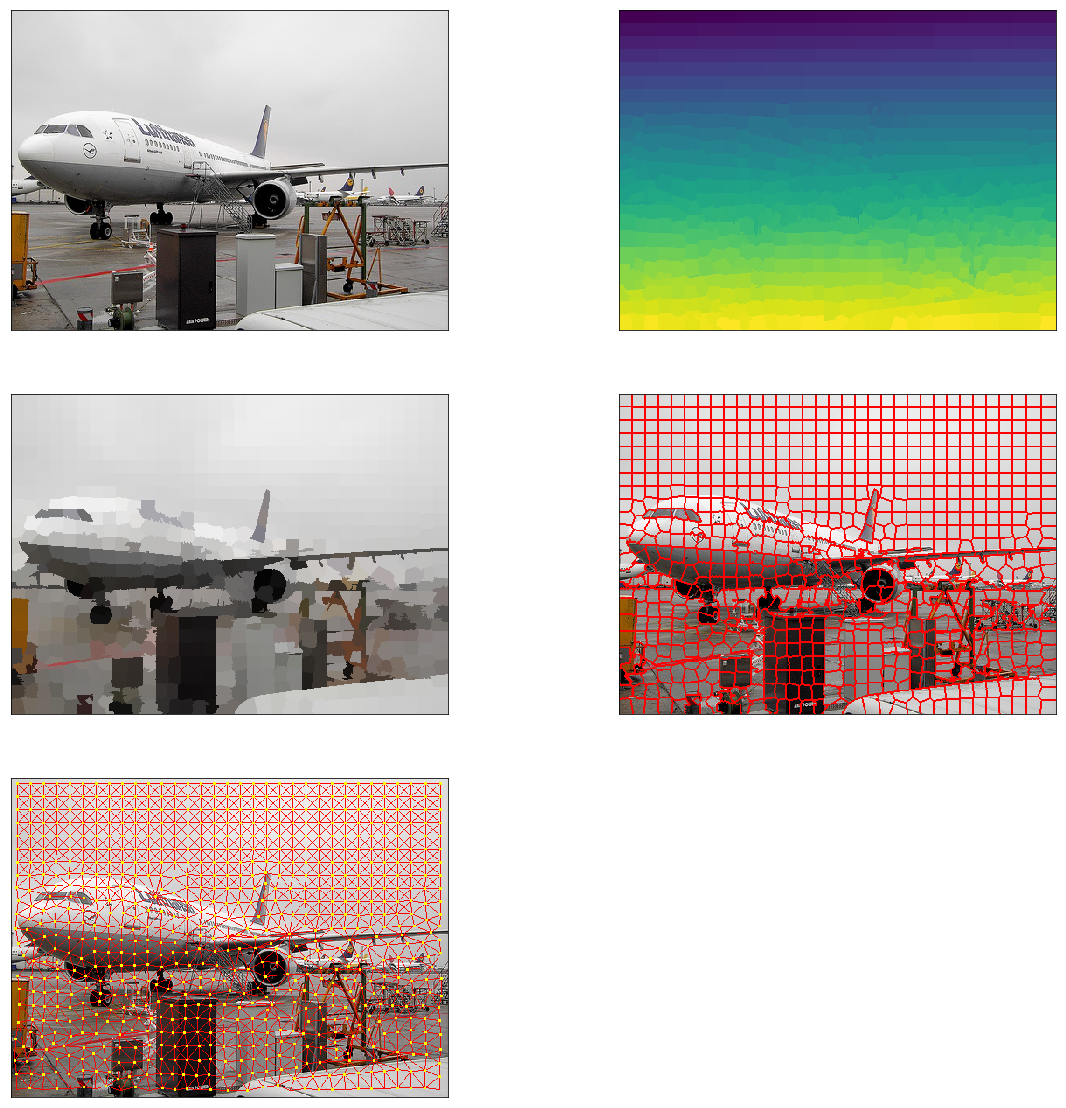

Execution time: 0.22972s
Number of segments: 763


In [89]:
NUM_SEGMENTS = 800
COMPACTNESS = 30
MAX_ITERATIONS = 10
SIGMA = 0.0

t_start = time.process_time()
labels = slic(image, NUM_SEGMENTS, COMPACTNESS, MAX_ITERATIONS, SIGMA)
duration = time.process_time() - t_start

showcase_image_segmentation(image, labels, duration, scale=1)

## Quickshift

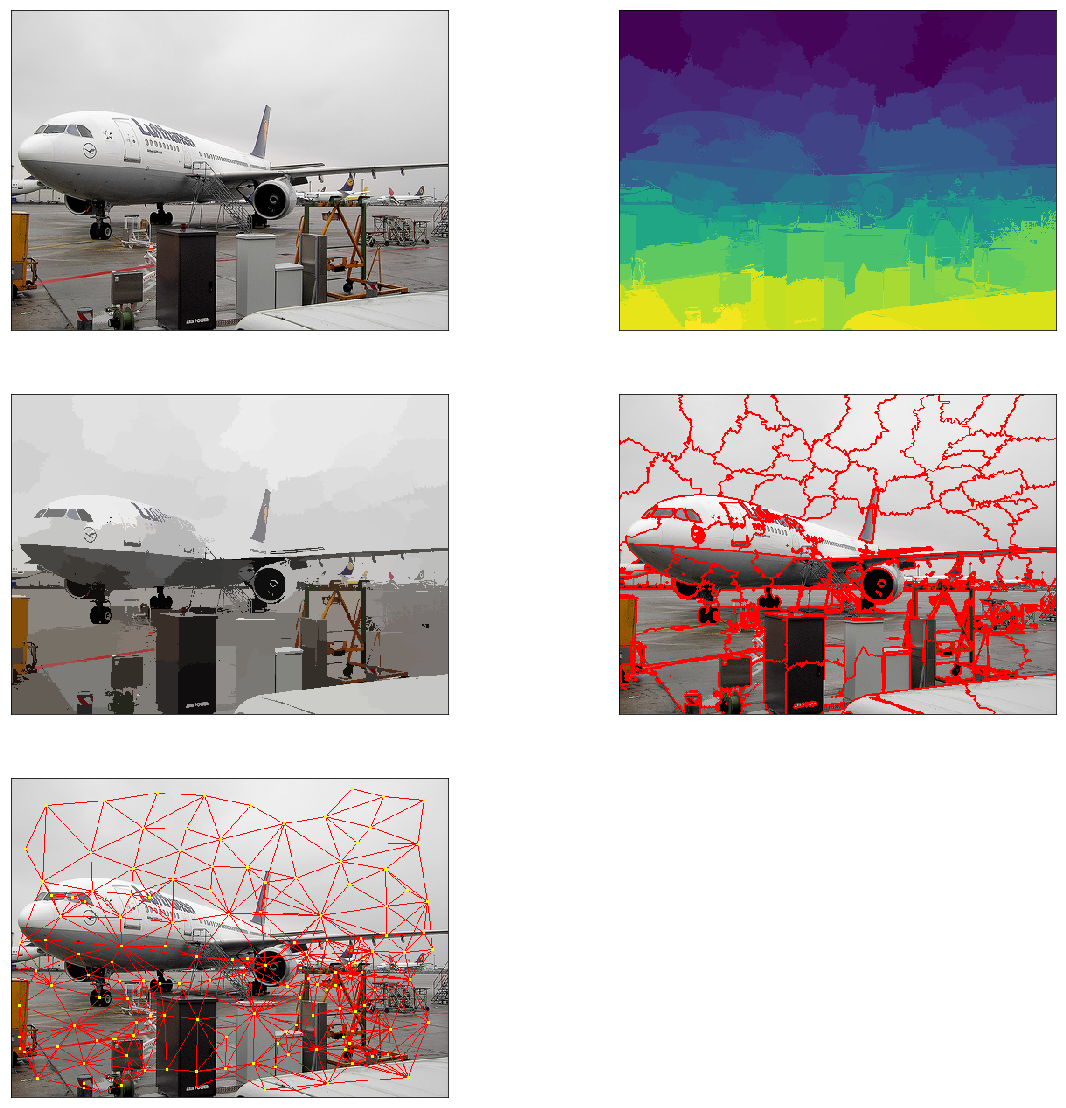

Execution time: 3.39686s
Number of segments: 161


In [90]:
RATIO = 1
KERNEL_SIZE = 5
MAX_DIST = 20
SIGMA = 0

t_start = time.process_time()
labels = quickshift(image, RATIO, KERNEL_SIZE, MAX_DIST, SIGMA)
duration = time.process_time() - t_start

showcase_image_segmentation(image, labels, duration, scale=1)

## Felzenszwalb

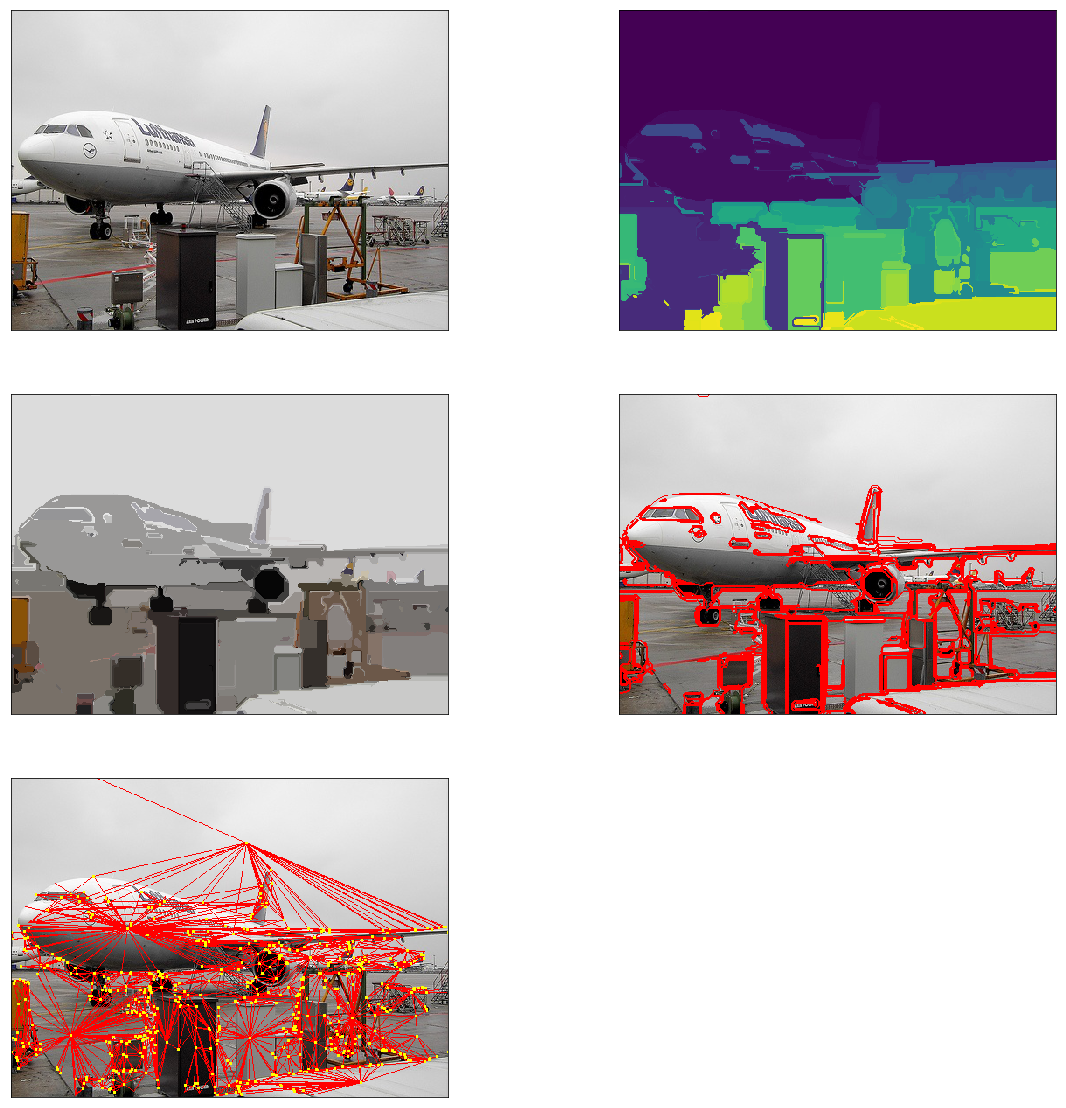

Execution time: 0.80432s
Number of segments: 716


In [99]:
SCALE = 200
MIN_SIZE = 10
SIGMA = 2

t_start = time.process_time()
labels = felzenszwalb(image, SCALE, MIN_SIZE, SIGMA)
duration = time.process_time() - t_start

showcase_image_segmentation(image, labels, duration, scale=1)

In [65]:
image = imread('/tmp/pascal_voc/VOCdevkit/VOC2012/JPEGImages/2007_000323.jpg')
image = (1 / 255) * image.astype(np.float32)

## SLIC

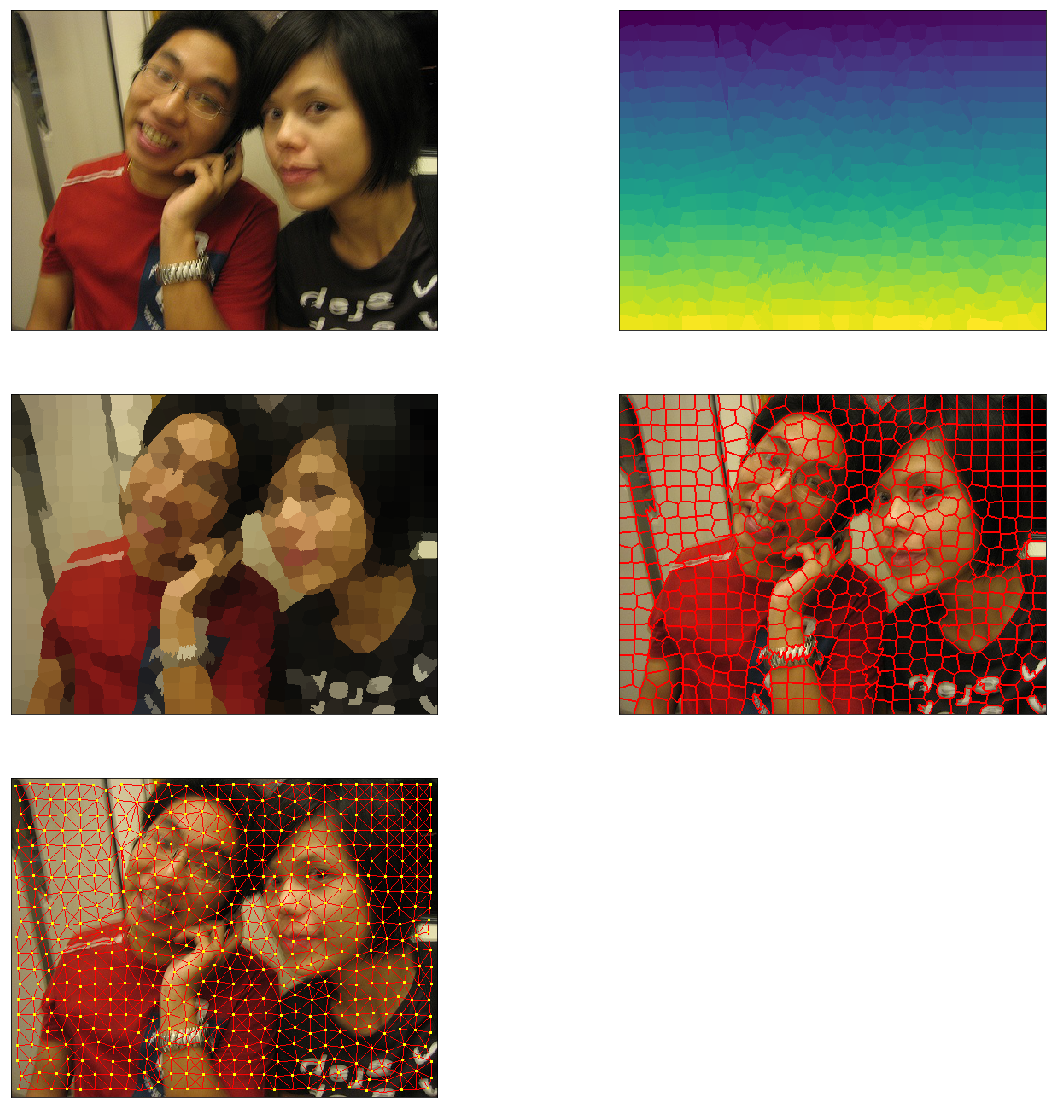

Execution time: 0.23497s
Number of segments: 581


In [66]:
NUM_SEGMENTS = 800
COMPACTNESS = 30
MAX_ITERATIONS = 10
SIGMA = 0.0

t_start = time.process_time()
labels = slic(image, NUM_SEGMENTS, COMPACTNESS, MAX_ITERATIONS, SIGMA)
duration = time.process_time() - t_start

showcase_image_segmentation(image, labels, duration, scale=1)

## Quickshift

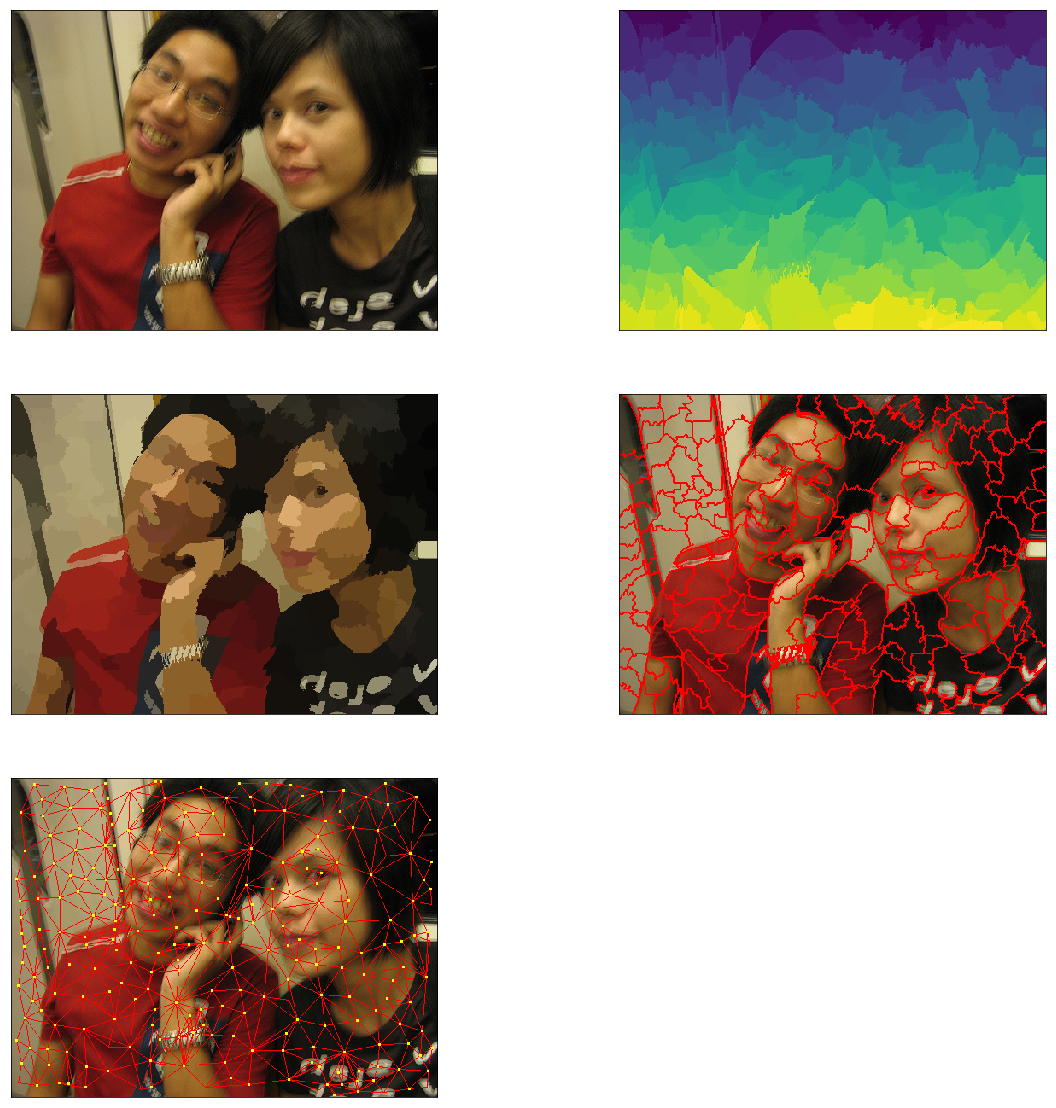

Execution time: 1.40223s
Number of segments: 260


In [67]:
RATIO = 1
KERNEL_SIZE = 5
MAX_DIST = 20
SIGMA = 0

t_start = time.process_time()
labels = quickshift(image, RATIO, KERNEL_SIZE, MAX_DIST, SIGMA)
duration = time.process_time() - t_start

showcase_image_segmentation(image, labels, duration, scale=1)

## Felzenszwalb

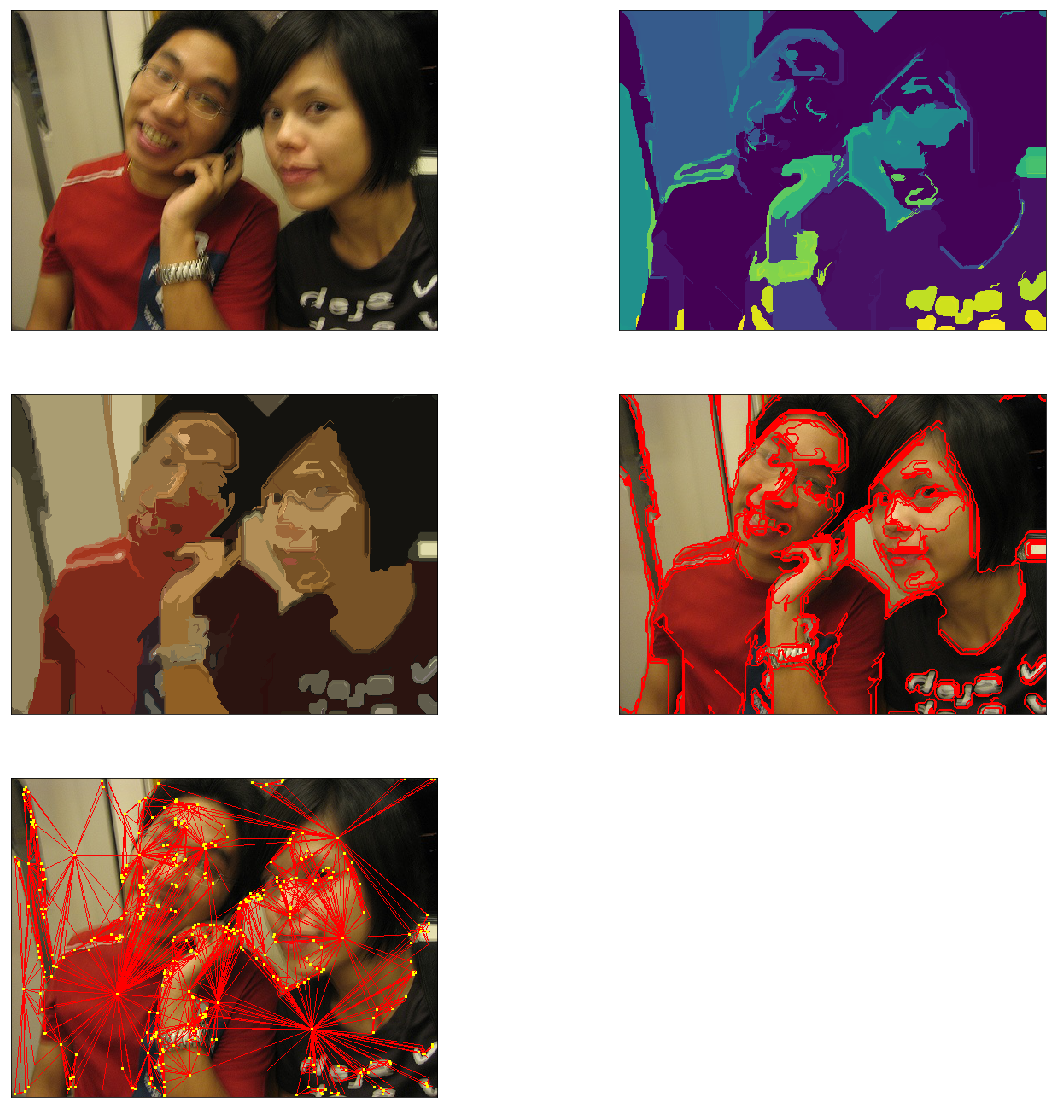

Execution time: 0.84613s
Number of segments: 551


In [68]:
SCALE = 200
MIN_SIZE = 10
SIGMA = 2

t_start = time.process_time()
labels = felzenszwalb(image, SCALE, MIN_SIZE, SIGMA)
duration = time.process_time() - t_start

showcase_image_segmentation(image, labels, duration, scale=1)